In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    pairwise_distances_argmin_min
)

from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d


In [2]:
# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos.csv"
SEED      = 42
MAX_ITER  = 2000

# ==== 1) Ler matriz ====
X = pd.read_csv(ARQ_IN, index_col=0)
X = X.clip(lower=0).astype(float)


In [3]:
print(f"Dimensões da matriz X: {X.shape}")  # (n_frames, n_cells)


Dimensões da matriz X: (1016, 1075)


Teste de K para NMF:   0%|          | 0/49 [00:00<?, ?it/s]

K  | Divergência KL | Melhoria relativa
2   | 229317 | ---
3   | 206356 | 0.10012493841065429
4   | 198299 | 0.03904728113067948
5   | 192312 | 0.030187767738853774
6   | 187342 | 0.025843792925927183
7   | 182728 | 0.02463143210860941
8   | 178934 | 0.020763530733815
9   | 174661 | 0.023878185020170244
10  | 172228 | 0.013930312208193985
11  | 167892 | 0.02517779412248988
12  | 166318 | 0.009371266395804854
13  | 162587 | 0.022435844491243744
14  | 161366 | 0.007509623549311126
15  | 156780 | 0.02841906507836835
16  | 154586 | 0.01399485325597591
17  | 152786 | 0.01164584666621835
18  | 149427 | 0.021985045241564784
19  | 150052 | -0.004182679093751996
20  | 146067 | 0.02655637605053177
21  | 144081 | 0.013597112897232637
22  | 142481 | 0.011104802385128645
23  | 141166 | 0.00922564910213615
24  | 139501 | 0.011796847219908495
25  | 137085 | 0.017317661045075882
26  | 135962 | 0.00819279582976145
27  | 133891 | 0.015232082971153362
28  | 132432 | 0.010894528664323042
29  | 130343 | 0.

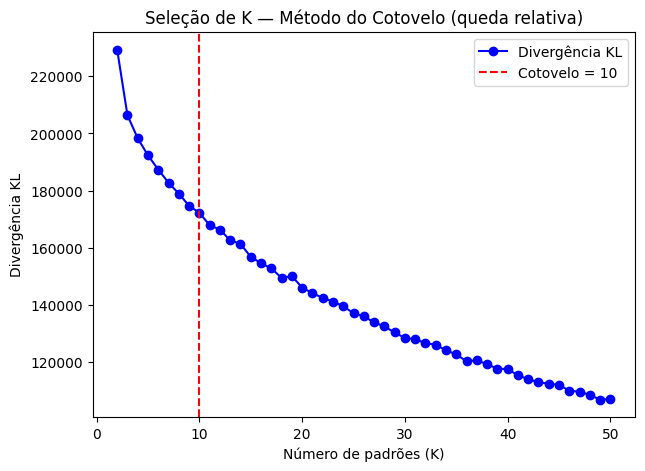

In [6]:
# método do cotovelo com critério de queda relativa da Divergência KL.
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d

errs, Ks = [], []
n_samples, n_features = X.shape

for K in tqdm(range(2, min(50, n_samples, n_features) + 1), desc="Teste de K para NMF"):
    nmf = NMF(
        n_components=K,
        init="nndsvda",
        solver="mu",
        beta_loss="kullback-leibler",
        max_iter=MAX_ITER,
        random_state=SEED
    )
    W = nmf.fit_transform(X.values)
    H = nmf.components_
    
    # Divergência KL
    X_hat = W @ H
    mask = X.values > 0
    kl = np.sum(
        X.values[mask] * np.log(X.values[mask] / np.maximum(X_hat[mask], 1e-10))
        - X.values[mask] + X_hat[mask]
    )
    errs.append(kl)
    Ks.append(K)

errs = np.array(errs, dtype=float)

# Calcular melhoria relativa de KL
drops = np.r_[np.nan, np.diff(errs) * -1]   # quedas absolutas
rel = drops / np.r_[np.nan, errs[:-1]]      # quedas relativas
limite = 0.02  # 2% como threshold (podes ajustar para 5%)

# Encontrar o primeiro K onde a melhoria cai abaixo do limite
idx = np.where(rel < limite)[0]
K_cotovelo = Ks[idx[0]] if len(idx) else Ks[np.argmin(errs)]

# Fixar K escolhido pelo método do cotovelo
K_final = K_cotovelo  

print("K  | Divergência KL | Melhoria relativa")
for i, K in enumerate(Ks):
    print(f"{K:<3} | {errs[i]:.6g} | {rel[i] if not np.isnan(rel[i]) else '---'}")

print(f"\n➡️  K escolhido pelo cotovelo (queda relativa < {limite*100:.0f}%): {K_final}")

# Gráfico
plt.figure(figsize=(7,5))
plt.plot(Ks, errs, marker="o", color="blue", label="Divergência KL")
plt.axvline(K_cotovelo, color="r", linestyle="--", label=f"Cotovelo = {K_cotovelo}")
plt.xlabel("Número de padrões (K)")
plt.ylabel("Divergência KL")
plt.title("Seleção de K — Método do Cotovelo (queda relativa)")
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# ==== Grid Search para parâmetros de regularização (K fixo = cotovelo) ====
from itertools import product

# Valores de regularização
alpha_H_vals = [0.0, 0.01, 0.1]
alpha_W_vals = [0.0, 0.01, 0.1]
l1_ratio_vals = [0.0, 0.5, 1.0]

resultados = []
Hs_dict = {}
Ws_dict = {}

for alpha_H, alpha_W, l1_ratio in product(alpha_H_vals, alpha_W_vals, l1_ratio_vals):
    nmf = NMF(
        n_components=K_final,
        init="nndsvda",
        solver="mu",
        beta_loss="kullback-leibler",
        max_iter=MAX_ITER,
        random_state=SEED,
        alpha_H=alpha_H,
        alpha_W=alpha_W,
        l1_ratio=l1_ratio
    )
    W = nmf.fit_transform(X.values)
    H = nmf.components_

    # Divergência KL
    X_hat = W @ H
    mask = X.values > 0
    kl = np.sum(
        X.values[mask] * np.log(X.values[mask] / np.maximum(X_hat[mask], 1e-10))
        - X.values[mask] + X_hat[mask]
    )

    resultados.append((alpha_H, alpha_W, l1_ratio, kl))
    Hs_dict[(alpha_H, alpha_W, l1_ratio)] = H
    Ws_dict[(alpha_H, alpha_W, l1_ratio)] = W

# Guardar resultados num DataFrame
df_grid = pd.DataFrame(resultados, columns=["alpha_H", "alpha_W", "l1_ratio", "KL_div"])
df_grid = df_grid.sort_values("KL_div").reset_index(drop=True)

print(f"Resultados do grid search para K={K_final} (ordenados por KL):")
display(df_grid.head())

# === Seleção automática da melhor combinação ===
best_combo = tuple(df_grid.loc[0, ["alpha_H", "alpha_W", "l1_ratio"]])
print(f"➡️ Melhor combinação encontrada: alpha_H={best_combo[0]}, alpha_W={best_combo[1]}, l1_ratio={best_combo[2]} (K={K_final})")

# Recuperar W e H correspondentes
W_best = Ws_dict[best_combo]
H_best = Hs_dict[best_combo]

# Criar DataFrame df_W final (para clustering)
df_W = pd.DataFrame(W_best, index=X.index, columns=[f"padrao_{i+1}" for i in range(W_best.shape[1])])

# Guardar também H_best se precisares
df_H = pd.DataFrame(H_best, columns=X.columns, index=[f"padrao_{i+1}" for i in range(H_best.shape[0])])

print("✅ df_W e df_H prontos para a continuação do pipeline.")


Resultados do grid search para K=10 (ordenados por KL):


,alpha_H,alpha_W,l1_ratio,KL_div
0,0.0,0.10,0.0,171889.547701
1,0.0,0.01,0.5,171985.264793
2,0.0,0.10,0.5,171993.865464
3,0.0,0.01,0.0,172019.273423
4,0.0,0.10,1.0,172142.486186


➡️ Melhor combinação encontrada: alpha_H=0.0, alpha_W=0.1, l1_ratio=0.0 (K=10)
✅ df_W e df_H prontos para a continuação do pipeline.


In [ ]:
# ==== Métricas de erro (NMF final, KL) ====

# Divergência KL
mask = X.values > 0
kl_div = np.sum(
    X.values[mask] * np.log(X.values[mask] / np.maximum(X_hat[mask], 1e-10))
    - X.values[mask] + X_hat[mask]
)

# RMSE e MAE auxiliares
diff = X.values - X_hat
rmse = np.sqrt((diff ** 2).mean())
mae  = np.abs(diff).mean()

print(f"Divergência KL: {kl_div:.6f}")
print(f"RMSE: {rmse:.6f}, MAE: {mae:.6f}")


Divergência KL: 253313.772840
RMSE: 0.777420, MAE: 0.100578


In [ ]:
df_W.to_csv("nmf_output_W.csv")
